# "Monte Carlo Methods 4: Integration"
> "In this blog post we turn our attention away from sampling from generic distributions to the problem of Monte-Carlo integration. Building up from a simple estimator we look at various variance reduction methods and approximations."
- toc: true
- author: Lewis Cole (2020)
- branch: master
- badges: false
- comments: false
- categories: [Monte-Carlo, Statistics, Probability, Computational-Statistics, Theory, Computation]
- hide: false
- search_exclude: false
- image: https://github.com/lewiscoleblog/blog/raw/master/images/Monte-Carlo/integral.png

In [1]:
#hide
import warnings
warnings.filterwarnings('ignore')

___
This is the fourth blog post in a series - you can find the previous blog post [here](https://lewiscoleblog.com/monte-carlo-methods-3)
___

In the previous few blog posts we have looked at how to sample from both univariate and multi-variate distributions. We now move onto another of main "themes" of Monte-Carlo method: the integration problem.

## Naïve Monte-Carlo Integration
Recall from our first blog post in this series we looked at how to estimate $\pi$ using a PRNG. This is an example of a Monte-Carlo integration. Instead of using a counting argument based around covering the shape with small simple shapes of known volume (i.e. traditional analytic integration) instead we simply fire "paintballs" at the shape and count the proportion landing inside. We can do this for generic functions too. Suppose we have a function $f(.)$ and we want to calculate: $I = \int_0^1 f(x) dx$. Then for a sequence of uniform variates $(u_1,...,u_N)$ we can take the estimator: $\hat{I} = \frac{1}{N} \sum_{i=1}^N f(u_i)$. The similarities to the $\pi$ example should be clear. Let's consider a specific example:

$$f(x) = \frac{\log(\Gamma(e^{\sin(x)+\cos(x)}))}{\log(\Gamma(e^{\sin(x)}))+\log(\Gamma(e^{\cos(x)}))} $$

Which we want to integrate over one full period $x \in [0, 2\pi]$:

$$ I = \int_0^{2\pi} \frac{\log(\Gamma(e^{\sin(x)+\cos(x)}))}{\log(\Gamma(e^{\sin(x)}))+\log(\Gamma(e^{\cos(x)}))} dx $$

There is no real meaning to this function, I just wanted to pick something sufficiently complicated that the integral would not exist in analytic form (even Wolfram Alpha does not give me an approximate integral value!). We can create a Monte-Carlo estimator of this integral below:

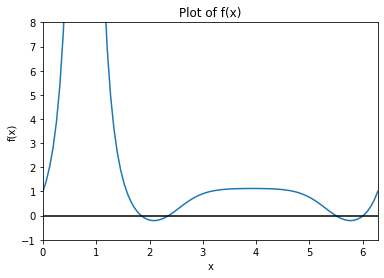

Estimated area under curve for 1 million samples: 5.222711387883453


In [1]:
# Basic Monte-Carlo Integration Estimator

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
%matplotlib inline

# Define function for integration
def f(x):
    return np.log(gamma(np.exp(np.sin(x)+np.cos(x)))) / ( np.log(gamma(np.exp(np.sin(x)))) + np.log(gamma(np.exp(np.cos(x)))) )

# Create samples function
def samples(func, steps, a=0, b=2*np.pi):
    # Create uniform variates
    U = np.random.random(steps)*(b-a)+a
    
    return func(U)

# Define integrator function
def integrate_1d(func, steps, a=0, b=2*np.pi):
    vals = samples(func, steps, a, b)
    
    # Return integral estimate
    return vals.sum() / steps

# Plot function
x = np.linspace(0, 2*np.pi, 100)
y = f(x)

plt.plot(x, y)
plt.ylim(-1,8)
plt.xlim(0, 2*np.pi)
plt.axhline(y=0, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x)')
plt.show()

# Print integral estimate
print("Estimated area under curve for 1 million samples:", integrate_1d(f, 1000000))

(Note: this function does not have a discontinuity - however the peak is very high c.80 so the full range is not shown in the graph above.)

### Central Limit Theorem for Monte Carlo Integration

We can see that our estimated integral is around $5.2$, however at this stage we have no idea whether this is a "good" estimate or a "bad" estimate. In the (rather contrived) $\pi$ estimate example we had some idea of what the value "should" be but in this case we do not have any real intuition. We can look at the graph and try and convince ourselves the estimate is reasonable but how do we know? Thankfully we can rely on some theory to help us gain a better understanding.

To better understand the properties of our estimator we rely on the central limit theorem (CLT):

____
**Theorem: Central Limit Theorem (for Monte Carlo)**

Suppose we wish to estimate the integral:

$$\mathbb{E}_f[h(X)] = \int h(x)f(x) dx$$

For some variable $X$ with pdf $f$. We can approximate this with a uniform sample via:

$$\overline{h}_N = \frac{1}{N} \sum_{i=1}^N h(u_i)$$

For $u_i$ iid samples from the uniform distribution. We let:

$$\overline{v}_N = \frac{1}{N^2} \sum_{i=1}^N (h(u_i) - \overline{h}_N)^2$$

Then assuming $\mathbb{E}_f[h(X)]$ and $\operatorname{Var}_f[h(X)]$ both exist and are finite then:

$$ \frac{\overline{h}_N - \mathbb{E}_f[h(X)] }{\sqrt{\overline{v}_N}} \xrightarrow[N \to \infty]{\text{D}} \mathcal{N}(0,1) $$

That is the sample mean $\overline{h}_N$ converges in distribution to a Gaussian distribution.
___


We can use this result in a number of ways, for example we can calculate a 95% confidence interval using our estimator above:

In [22]:
from scipy.stats import norm

# Number of Samples
N = 1000000

# Create Samples
samp = samples(f, N)

# Calculate h_N and v_N
h_N = samp.sum() / N
v_N = (samp - h_N)**2
v_N = v_N.sum() / N**2

# Find 95th percentile of standard normal
pt = norm.ppf(0.975)

# Create confidence interval
CI = [ h_N - pt*np.sqrt(v_N), h_N + pt*np.sqrt(v_N)]

# Print results
print("Integral Estimate:", h_N)
print("95% Confidence Interval:", CI)

Integral Estimate: 5.212267819546782
95% Confidence Interval: [5.184822438263345, 5.239713200830219]


This gives us some idea of how "good" our estimator is, we would expect to see a random estimate using this method to fall outside this range only 1 in 20 attempts. Depending on our application this may or may not be acceptable. We can of course increase the number of samples to improve this estimate if we wanted to. Further we know that if we increase the number of samples to $N' = \Delta N$ - then the variance should decrease by a factor $\Delta$ and so we can use this to work out how many samples should be required to get to a specific level of desired accuracy. 

To check the confidence interval makes sense we can repeatedly sample and create an empirical 95% confidence interval:

In [23]:
# N is number of samples per estimate
N = 1000000

# M is the number of samples of h_N
M = 1000

h_N_M = np.zeros(M)

for i in range(M):
    h_N_M[i] = integrate_1d(f, N)
    
CI_emp = [np.percentile(h_N_M, 2.5), np.percentile(h_N_M, 97.5)]

print("Empirical Confidence Interval:", CI_emp)
print("CLT Confidence Interval", CI)

Empirical Confidence Interval: [5.2009155048412, 5.256399451162318]
CLT Confidence Interval [5.184822438263345, 5.239713200830219]


We can see that the empirical and CLT derived confidence intervals are reasonably close, which is what we expect. It is always worth remembering that in calculating any quantity witha Monte-Carlo method (or working with "real" data) any summary statistic or quantity calculated is itself nothing more than a sample from a distribution! We therefore need to treat it only as an estimate (not realising this is one of the most significant causes of incorrect conclusions being drawn from models/data!)

## Riemann Approximation
Thinking once again about our integral in general terms:

$$ I = \mathbb{E}_f(h(X)) = \int_D h(x)f(x) dx$$

Let's not see if we can improve upon this estimate. If we were to approach this in a Riemann (analytic) way we would consider a sequence of ordered sequences $(a_{i,n})_{i=1}^n$ such that: $|a_{i+1,n} - a_{i,n}| \xrightarrow{n \to \infty}  0$. We then approximate the integral via:

$$ I_n = \sum_{i=0}^{n-1} h(a_{i,n})f(a_{i,n})(a_{i+1,n} - a_{i,n}) $$

We can mimic this approach in a Monte-Carlo setting by sampling $(x_1,...,x_N)$ iid rom $f(.)$ such that: $x_1 \leq ... \leq x_N$ and taking:

$$ I_N \approx \sum_{i=0}^{N-1} h(x_i)f(x_i)(x_{i+1} - x_i) $$

This estimator has variance of order $\mathcal{O}(N^{-2})$ which we can improve further by taking the average value:

$$ I_N \approx \sum_{i=0}^{N-1} \frac{h(x_{i+1}) - h(x_i)}{2}f(x_i)(x_{i+1} - x_i) $$

If the second derivative of $h(.)$ is bounded then we have an estimator with variance $\mathcal{O}(N^{-4})$. On the surface this appears to be an incredibly powerful method since the simple Monte-Carlo estimator we looked at initially has variance $\mathcal{O}(N^{-1})$. However things are not that easy, the Riemann approximation method essentially "covers" the entire space, so in 1d this is very efficient. However as soon as we increase the dimensionality of the space this becomes less efficient. In fact for dimension $d$ the Riemann approximation (assuming bounded second derivative) is: $\mathcal{O}(N^{-4/d})$ - this is called the curse of dimensionality and is why Monte-Carlo methods can be so useful in estimating complex high dimensional integrals! Say we are looking at an integral in $12$ dimensions then the Riemann estimator would have variance  $\mathcal{O}(N^{-1/3})$ - whereas the naïve approach would still have variance $\mathcal{O}(N^{-1})$. The naïve approach having a significant improvement in variance.

## Importance Sampling
With the naïve Monte-Carlo example above we have attacked the problem in quite a "natural" way, we have some sense of how "good" the estimator of our integral is thanks to calculating $\overline{v}_N$ the sample variance of the estimator. This statistic allows us to "compare" estimators, an estimator with a lower variance being "better". We also note that we could have parameterized this integral in any number of ways, for example we could take a change of variable (e.g. $y = \log(x)$) or in some cases we could rely on a geometric argument (e.g. if the integral is symmetrical around some value) - this can allow us to sample points more "efficiently" to create a better estimate for a given number of samples. However practically we always have to weigh this up against how long it takes to create a sample (e.g. if there is a transform that leads to a better variance but each sample takes 1000 times longer to generate it may not be wise to take the "better" estimator!)

We now look further at this idea through the concept of Importance sampling:

___
**Definition: Importance Sampling**

Let $(x_1,...,x_N)$ be samples according to some distribution function $g(.)$. The the importance sampling method can be represented:

$$\mathbb{E}_f[h(X)] \approx \frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{g(x_i)}h(x_i) $$ 

This follows from re-expressing the expectation as:

$$\mathbb{E}_f[h(X)] = \int h(x)f(x) dx = \int h(x) \frac{f(x)}{g(x)} g(x) dx $$
___

Notice how we do not have many constraints on the choice of distribution $g(.)$, importance sampling is therefore a very powerful method. We can also generate our samples and use them repeatedly for different choices of $f(.)$ and $h(.)$ which can be useful in certain circumstances.

To illustrate this power we look at an example of estimating the frequency of a rare event. Suppose $Z \sim \mathcal{N}(0,1)$ and we wish to estimate $\mathbb{P}(Z > 5)$. The naive approach would be to use:

$$ \mathbb{P}(Z > 5) \approx \frac{1}{N} \sum_{i=1}^N \mathbb{1}(z_i > 5) $$

For $z_i$ iid realisations of the standard Gaussian. If we try this even with $N=10,000$ we're not likely to find any samples above the threshold and so our estimate will most likely be zero. If instead we take $Y \sim \mathcal{TE}(5,1)$ - that is an exponential distribution truncated at 5 with scale 1. The density function being:

$$ f_Y(y) = \frac{e^{-(y-5)}}{\int_{5}^{\infty} e^{-(x-5)}dx} $$

With $y_i$ iid samples from this distribution we can use the estimator:

$$ \mathbb{P}(Z > 5) \approx \frac{1}{N} \sum_{i=1}^N \frac{\phi(y_i)}{f_Y(y_i)} \mathbb{1}(y_i > 5) $$

Which should lead to better performance. Let's take a look at this in action:

In [37]:
# Importance Sampling Example
# Estimating tail probability of a standard normal

import numpy as np
from scipy.stats import norm, expon

# Set number samples
N = 10000
thresh = 5

# Naive estimate
Z = norm.rvs(size=N) > thresh
naive_est = Z.sum() / N

# Importance Sampling estimate
Y = expon.rvs(loc=thresh, scale=1, size=N)
h = norm.pdf(Y)/expon.pdf(Y, loc=thresh, scale=1) * (Y > thresh)
IS_est = h.sum() / N

print("Naive Tail Probability Estimate:", naive_est)
print("Importance Sampling Tail Probability Estimate:", IS_est)

Naive Tail Probability Estimate: 0.0
Importance Sampling Tail Probability Estimate: 2.8430113423144186e-07


We can see that with just $10,000$ samples we have been able to create an estimate for a probability that has a return period of the order of $10,000,000$ - far in excess of the number of samples. This is an incredibly powerful concept. To find a suitable instrumental distribution we relied on the theory of large deviations - we will not cover this here but it may form a future blog post. 

Although there is (next to) no restrictions on the instrumental distribution $g(.)$ used for importance sampling, clearly some distributions will work better than others. How can we select a "good" distribution? Firstly we have that the variance of the importance sampling estimator is finite only when:

$$ \mathbb{E}_g\left[h^2(X) \frac{f^2(X)}{g^2(X)}\right] = \mathbb{E}_f\left[h^2(X) \frac{f(X)}{g(X)}\right] < \infty$$

We thus have that $g(.)$ with lighter tails than $f(.)$ are not appropriate for importance sampling since they lead to estimators of infinite variance. This leads to two sufficient conditions for finite variance estimators:

1. $\frac{f(x)}{g(x)} < M$ for some $M$ for all $x$ and $\operatorname{Var}_f(h)<\infty$
2. $X$ has compact support with $f(x) < F$ for some $F$ and $g(x)> \epsilon$ for all $x$

An alternate form of the importance sampling estimator that sometimes performs better than the form above is:

$$ I \approx \frac{\sum\limits_{i=1}^N h(x_i) \frac{f(x_i)}{g(x_i)}}{\sum\limits_{i=1}^N \frac{f(x_i)}{g(x_i)}} $$

This works since: $\frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{g(x_i)} \xrightarrow{\text{a.s}} 1$. The estimator is itself biased, albeit with small bias. The reduction in variance can be worth the reduction in bias.

___
**Theorem:**

The selection of $g(.)$ that minimises the variance of an importance sampling estimator is:

$$ g^*(x) = \frac{|h(x)|f(x)}{\int |h(z)| f(z) dz} $$
___
**Proof:**

Recall overall variance of the estimator can be expressed as sums of variances of the form:

$$\operatorname{Var}\left[ \frac{h(X)f(X)}{g(X)} \right] = \mathbb{E}_g\left[h^2(X) \frac{f^2(X)}{g^2(X)}\right] - \left( \mathbb{E}_g\left[\frac{h(X)f(X)}{g(X)}\right]\right)^2 $$

We note that the second term of this sum does not depend on $g(.)$ at all and so it suffices to minimize the first term. By Jensen's inequality we have:

$$ \mathbb{E}_g\left[h^2(X) \frac{f^2(X)}{g^2(X)}\right] \geq \left( \mathbb{E}_g\left[\frac{h(X)f(X)}{g(X)}\right]\right)^2 = \left( \int |h(z)| f(z) dz \right)^2 $$

Which provides us with the lower bound $g^*(.)$.  $\square$
___

Unfortunately our bound requires us to know about: $\int h(x)f(x) dx$ which is preciesly the integral we're looking to evaluate! Practically we look for $g(.)$ such that $\frac{|h(.)|f(.)}{g(.)}$ is almost constant with finite variance. Further importance sample will perform poorly if:

$$ \int \frac{f^2(x)}{g(x)} dx = \infty $$



## Rao-Blackwell Method
We now look at another method for reducing the variance of an estimator through the use of the Rao-Blackwell theorem. Suppose we have some estimator: $\delta(X)$ some function of a random-variable $X$ that estimates some parameter $\theta$. Given a sufficient statistic for the parameter: $T(X)$ then we can define the Rao-Blackwell estimator as:

$$ \delta_1(X) = \mathbb{E}[\delta(X) | T(X)] $$

We can note that the variance of $\delta_1(X)$ has be less than (or equal to) the variance of estimator $\delta$ - why is this? By looking at the mean square error we have:

$$ \mathbb{E} [(\delta _{1}(X)-\theta )^{2}] = \mathbb{E} [(\delta (X)-\theta )^{2}]- \mathbb{E} [\operatorname {Var} (\delta (X)\mid T(X))] $$

Since variance is always positive this leads to:

$$ \mathbb{E} [(\delta _{1}(X)-\theta )^{2}] \leq \mathbb{E} [(\delta (X)-\theta )^{2}] $$

Which means the variance must also decrease via the Rao-Blackwell estimate.

In the context of Monte-Carlo integration however we can "drop" the requirement of sufficient statistics on the conditioning variable. Suppose again our quantity of interest is:

$$I = \mathbb{E}_f[h(X)] $$

If we have a joint distribution function $g(x,y)$ for variables $(X,Y)$ such that:

$$ \int g(x,y) dy = f(x) \quad \forall x $$

Then we can take the Rao-Blackwell estimator to be:

$$ \delta_1(X) = \mathbb{E}_f[\delta(X)|Y] $$

And the argument above still holds leading to a reduced variance estimator. However the use of this method is itself rather limited due to the need to find suitable joint distribution functions and for the conditional expectations to have a convenient form (i.e. we would not want to have a Rao-Blackwell estimator that itself needed a Monte-Carlo method to evaluate!). In spite of this Rao-Blackwell methods can be quite powerful when combined with accept-reject style algorithms.

## Antithetic Sampling
Another way to reduce the variance of an estimator is to use an antithetic sampling procedure. The intuition behind this is fairly simple. So far we have talked about the need for "independent" samples for use in Monte-Carlo methods. There are times however when this is not always ideal. Let's suppose we are estimating two integrals: $I_1$ and $I_2$. To do this we create estimators: $\delta_1(.)$ and $\delta_2(.)$ respectively. Notice that if we are concerned with the quantity: $I_1 + I_2$, using our estimators we have:

$$ \operatorname{Var}[ \delta_1(X) + \delta_2(Y) ] = \operatorname{Var}[\delta_1(X)] + \operatorname{Var}[\delta_2(X)] + 2 \operatorname{Cov}[\delta_1(X), \delta_2(Y)] $$

We can then see that our estimator for $I_1+I_2$ has lowest variance when we have negative correlation between $\delta_1(X)$ and $\delta_2(Y)$!

But what options do we have to ensure this? Clearly we could rely on the multi-variate generation methods (e.g. copulae) from a previous blog post, but this is often overkill and the computational cost outweighs the reduction in variance. Fortunately we can overcome this problem very easily when using an inverse transform method - we generate a uniform variate: $u_i$ for use in the $\delta_1(.)$ estimator and then use $(1-u_i)$ for use in estimator $\delta_2(.)$.

For our integration problem this has the following interpretation:

$$ J_1 = \frac{1}{2N} \sum_{i=1}^N [h(F^{-1}(u_i)) + h(F^{-1}(1-u_i))] $$

Should achieve a better convergence (lower variance) than the estimator:

$$ J_2 = \frac{1}{2N} \sum_{i=1}^{2N} h(F^{-1}(u_i)) $$

Before considering the implications of generating an extra $N$ pseudo-random numbers. Let's take a look at an example of this in action. We will look to estimate the integral:

$$ \int_{0}^{1} \frac{1}{1+x} dx $$

We know that this can be evaluated analytically as $\ln(2)$ but we shall use Monte-Carlo to calculate it here. By taking $1,000$ estimators each with $N=1,000$ we can get an idea of the variance in the estimators:

In [12]:
# An example of antithetic sampling
# Note this is a slow running highly non-optimal code!

import numpy as np
from scipy.stats import norm
from scipy.special import gamma

# Fix number of estimators M and number of samples per estimate N/2
N = 1000
M = 1000

# Set up arrays of estimates
regular = np.zeros(M)
antithetic = np.zeros(M)

# Define h(x)
def h(x):
    return 1 / (1+x)

# Non-antithetic approach
for i in range(M):
    u = np.random.random(2*N)
    est = h(u)
    regular[i] = est.sum() / (2*N)

# Antithetic approach
for i in range(M):
    u = np.random.random(N)
    est = h(u) + h(1-u)
    antithetic[i] = est.sum() / (2*N)

# Calculate mean and variance of regular vs antithetic sample estimates
regular_mean = regular.mean()
regular_var = regular.std()**2

ant_mean = antithetic.mean()
ant_var = antithetic.std()**2

# Print results
print("Independent Sampling:")
print("Bias:", np.abs(regular_mean - np.log(2)), "Variance:", regular_var)
print("\n")
print("Antithetic Sampling:")
print("Bias:", np.abs(ant_mean - np.log(2)), "Variance:", ant_var)

Independent Sampling:
Bias: 3.633843451245067e-05 Variance: 9.813137160375326e-06


Antithetic Sampling:
Bias: 9.54802630492857e-06 Variance: 5.864033213624619e-07


We can see here that both sampling procedures produce reasonable estimates in terms of bias - the variance for the antithetic sampler is noticably less.

Of course this method is not without its issues: it is not necessarily a "pre-canned" solution and we have to think about the problem at hand. For very complicated models with many interacting components, implementing antithetic sampling can become so complicated that it makes the code too difficult to understand. Further we are generally unable to combine use this method when relying on accept/reject type methods of sampling - we are essentially limited to using inverse-transform methods which themselves can have their own set of issues (as noted in previous blog posts). Nonetheless antithetic sampling is a useful tool in the modellers arsenal.

## Laplace Approximations
We now move on to look at Laplace approximations to an integral. Unlike the methods shown previously they are not technically "Monte-Carlo" methods in the sense that they do not rely on pseudo-random number samples. Instead we apply some analytic approximations to our integrand in order to simplify its evaluation. This can be useful for problems where Monte-Carlo is prohibitively expensive and the approximations calculated can be used as a guide or "ballpark estimate" for sense checking the results of a more sophisticated Monte-Carlo simulation engine. We can also use the method as a way of generating proposal distributions when no obvious proposal exists for our Monte-Carlo method.

We will outline the Laplace procedure below (some of the more subtle details of the derivation are excluded). Suppose we have an integral of the form:

$$ I = \int_D f_{\theta}(x) dx $$

Where $D$ is some sub-domain of function $f_{\theta}$ with $\theta$ being some (fixed) parameter vector for the function (e.g $\mu$ and $\sigma$ for the Gaussian pdf). We will assume that $f(.)$ is non-negative and integrable (some extensions have been proposed to drop these requirements but we shall make this assumption for now). If we re-write $f(.)$ in the form: $f_{\theta}(x) = e^{n h_{\theta}(x)}$ (hence for the need for $f(.)$ to be non-negative). Then we can write:

$$ I = \int_D e^{n h_{\theta}(x)} dx $$

We can write a Taylor expansion of $h_{\theta}(.)$ about the point $x_0$ via:

$$ h_{\theta}(x) \approx h_{\theta}(x_0) + (x-x_0)h'_{\theta}(x_0) + \frac{(x-x_0)^2}{2!}h''_{\theta}(x_0) + \frac{(x-x_0)^3}{3!}h'''_{\theta}(x_0) + \mathcal{O}((x-x_0)^3) $$

Where: $\mathcal{O}(.)$ is big-O notation. If we pick $x_0$ to be an attained maximum of the function $h_{\theta}(.)$ then the first derivative is zero and so we have (ignoring the big-O term):

$$ h_{\theta}(x) \approx h_{\theta}(x_0) + \frac{(x-x_0)^2}{2!}h''_{\theta}(x_0) + \frac{(x-x_0)^3}{3!}h'''_{\theta}(x_0)$$

We can thus re-write an approximation to our integral as:

$$ I = e^{n h_{\theta}(x_0)} \int_D e^{n \frac{n(x-x_0)^2}{2}h''_{\theta}(x_0)} e^{\frac{n(x-x_0)^3}{3!}h'''_{\theta}(x_0)} dx $$

With $h'_{\theta}(x_0) = 0$ ($x_0$ attaining the maximum). We can now apply a second Taylor expansion to the term: $e^{\frac{n(x-x_0)^3}{3!}h'''_{\theta}(x_0)}$ - by noting $e^y \approx 1 + y + \frac{y^2}{2!} + \mathcal{O}(y^2)$. By taking the expansion around $x_0$ again we get:

$$ e^{\frac{n(x-x_0)^3}{3!}h'''_{\theta}(x_0)} \approx 1 + \frac{n(x-x_0)^3}{3!}h'''_{\theta}(x_0) + \frac{n^2(x-x_0)^6}{2!(3!)^2} (h'''_{\theta}(x_0))^2 + \mathcal{O}((x-x_0)^6) $$

By excluding the big-O term, we can plug this back into our integral approximation to give:

$$ I \approx e^{n h_{\theta}(x_0)} \int_D e^{n \frac{n(x-x_0)^2}{2}h''_{\theta}(x_0)} \left[  1 + \frac{n(x-x_0)^3}{3!}h'''_{\theta}(x_0) + \frac{n^2(x-x_0)^6}{2!(3!)^2} (h'''_{\theta}(x_0))^2 \right] dx $$

This is the 3rd order Laplace approximation to the integral. If we limit ourselves to the first order approximation:

$$ I \approx e^{n h_{\theta}(x_0)} \int_D e^{n \frac{n(x-x_0)^2}{2}h''_{\theta}(x_0)} $$

We see that the integrand is nothing more than the kernel of the Gaussian density with mean $x_0$ and variance $\frac{-1}{nh''_{\theta}(x_0)}$. If our integral domain is: $D = [a,b]$ - some line segment on the real line. we can write the Laplace approximation in the form: 

$$ I = \int_a^b f_{\theta}(x) dx \approx e^{n h_{\theta}(x_0)} \sqrt{\frac{-2\pi}{nh''_{\theta}(x_0)}} \left[ \Phi\left[\sqrt{-nh''_{\theta}(x_0)}(b-x_0)\right] -  \Phi\left[\sqrt{-nh''_{\theta}(x_0)}(a-x_0)\right]  \right] $$

Where $\Phi[.]$ is the CDF of the standard Gaussian. This provides us with a convenient way of estimating an integral without needing to produce samples from a distribution. Note: that by choosing $x_0$ to be the maximum we ensure: $h''_{\theta}(x_0) \leq 0$ and so all square-roots are defined in the approximation above.

Let's look at an example of this in action. We will take an example where we can calculate an exact analytic solution so we can see how the approximation behaves. We can take a Gamma integral:

$$ \int_a^b \frac{x^{\alpha-1}}{\Gamma(\alpha)\beta^{\alpha}} e^{-\frac{x}{\beta}} dx $$

We have:

$$ h_{\theta}(x) = - \frac{x}{\beta}+(\alpha -1) \log{x}$$

This function is maximized with: 

$$x_0 = (\alpha-1)\beta$$

For $\alpha, \beta > 1$. We therefore get the approximation:

$$ \int_a^b \frac{x^{\alpha-1}}{\Gamma(\alpha)\beta^{\alpha}} e^{-\frac{x}{\beta}} dx  \approx \frac{x_0^{\alpha-1} e^{-\frac{x_0}{\beta}}}{\Gamma(\alpha)\beta^{\alpha}} \sqrt{\frac{2\pi x_0^2}{\alpha -1}} \left[ \Phi\left[ \sqrt{\frac{\alpha-1}{x_0^2}}(b-x_0) \right] - \Phi\left[ \sqrt{\frac{\alpha-1}{x_0^2}}(a-x_0) \right]\right]  $$

We know that the exact value of this integral is:

$$ \int_a^b \frac{x^{\alpha-1}}{\Gamma(\alpha)\beta^{\alpha}} e^{-\frac{x}{\beta}} dx = \frac{ {\gamma\left(\alpha,{\frac {b}{\beta }}\right)} - {\gamma\left(\alpha,{\frac {a}{\beta }}\right)} }{\Gamma(\alpha)}$$

Where: $\gamma\left(\alpha,{\frac {(.)}{\beta }}\right)$ is the incomplete beta function. Let's look at the example with $\alpha = 3$ and $\beta = 4$ this leads to the maximum being attained at $x_0=8$. We will consider the the integral of the Gamma desity in the range: $[7,9]$ (in the general vicinity of the maxima) and the range $[25,27]$ (outside the general vicinity of the maxima).

In [31]:
# Integral of the Gamma Density
# Exact solution using Gamma CDF
# Approximation using first order Laplace approximation

import numpy as np
from scipy.stats import gamma, norm
import scipy.special

# Set parameters
alpha = 3
beta = 4

# Define function to evaluate exact integral
def exact_integral(alp, bet, top, bottom):
    return gamma.cdf(top, a=alp, scale=bet) - gamma.cdf(bottom, a=alp, scale=bet)

# Define function to evaluate Laplace approx. integral
def laplace_integral(alp, bet, top, bottom):
    x0 = (alp-1)*bet
    return x0**(alp-1)*np.exp(-x0/bet)*np.sqrt((2*np.pi*x0**2)/(alp-1))*(norm.cdf(np.sqrt((alp-1)/x0**2)*(top-x0))-norm.cdf(np.sqrt((alp-1)/x0**2)*(bottom-x0))) / (bet**alp * scipy.special.gamma(alp))

print("Exact Integral in range [7,9]:", exact_integral(alpha, beta, 9, 7))
print("Laplace Integral in range [7,9]:", laplace_integral(alpha, beta, 9, 7))
print("\n")
print("Exact Integral in range [25,27]:", exact_integral(alpha, beta, 27, 25))
print("Laplace Integral in range [25,27]:", laplace_integral(alpha, beta, 27, 25))

Exact Integral in range [7,9]: 0.13463042839894013
Laplace Integral in range [7,9]: 0.13463370379908948


Exact Integral in range [25,27]: 0.015951556413567713
Laplace Integral in range [25,27]: 0.0008976580106864617


We can see that the approximation is very accurate around $x_0$ but performs much worse in when further away from this value. This is worth keeping in mind when relying on a Laplace approximation procedure.

## Conclusion
In this blog post we have looked at the basics of using Monte-Carlo to solve integration problems. We have seen how unlike "traditional" methods Monte-Carlo does not suffer from the "curse of dimensionality" in quite the same way. Further we have seen that via construction we have methods for quantifying the variance of our estimators and so have the ability to "judge" whether an estimator will have suitable performance for our needs. Further we have seen a few various techniques that we can use to reduce the variance of our estimators in order to improve performance. Finally we looked at the Laplace transform as a method of estimating complex integrals when Monte-Carlo methods do not perform well and a "rough" estimate is required quickly. The Laplace estimator can also be used as a piece of validation to see whether our Monte-Carlo integral estimators are working as we would like.